## Result:

Optimizing the fwhm and wsum combination does not work even after calculating over noise.

# Autofocus


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from datetime import datetime
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from epics import ca

ca.finalize_libca()

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)

In [5]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "log_weighted_sum_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm": 0.02},
        }

In [18]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

    new_dir = work_dir / f"work_dir_{DEFAULT_RANDOM_SEED}"
    new_dir.mkdir(exist_ok=True)

    files = work_dir.glob("*")
    for f in files:
        if f.is_file():
            shutil.copy2(f, new_dir)
    os.chdir(new_dir)

In [26]:
def print_beam_attributes(cp, loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(
            opt_common._get_weighted_sum_intensity_from_hist(cp, hist, 2)
        )
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [34]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3
cp = opt_common.CalculationParameters(
    xrange=[-detector_x / 2, detector_x / 2],
    yrange=[-detector_y / 2, detector_y / 2],
    nbins_h=1024,
    nbins_v=1024,
    use_denoised=False,
    random_seed=111,
    add_noise=True,
    calculate_over_noise=False,
    noise_threshold=1.5,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
)

xrange_plot = [x / 5 for x in cp.xrange]
yrange_plot = [y / 5 for y in cp.yrange]

ppm = opt_common.PlotParameters(
    xrange=xrange_plot, yrange=yrange_plot, nbins_h=cp.nbins_h // 5, nbins_v=cp.nbins_v // 5
)  # xrange=xrange_plot, yrange=yrange_plot)#, )

In [20]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=0.5, percentage_fluctuation=50, calculate_over_noise=True, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)


In [22]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'loss_parameters': ['fwhm', 'log_weighted_sum_intensity'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [23]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


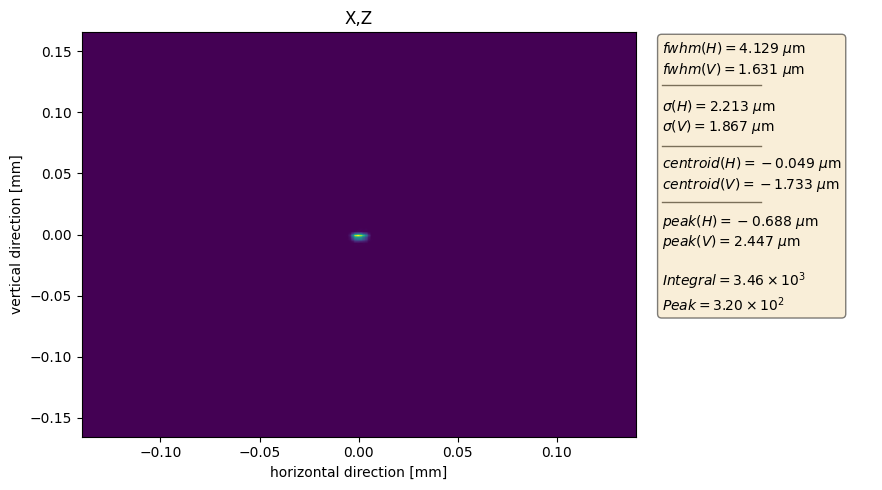

In [24]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [27]:
attribs_focus = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist, dw, "Focused beam")

Focused beam system fwhm: 4.423e-03
Focused beam system log_weighted_sum_intensity: -3.237e+00


In [28]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)

Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [29]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-166.5, -163.6, 0.17388733853924987, 0.0588, 411.79999999999995, 0.17001733853924986, 0.0149]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [1.473892169958841, -2.571738953207049, -0.0019608319449820684, 0.029438691659946392, -7.219875597608283, -0.0018682783160533481, 0.014866549049002302]


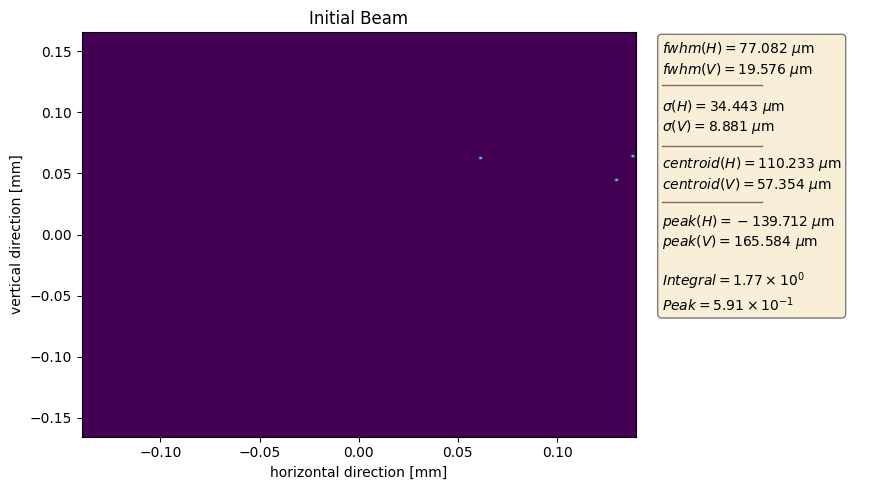

Perturbed beam system fwhm: 6.750e-02
Perturbed beam system log_weighted_sum_intensity: 4.940e+00


In [31]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

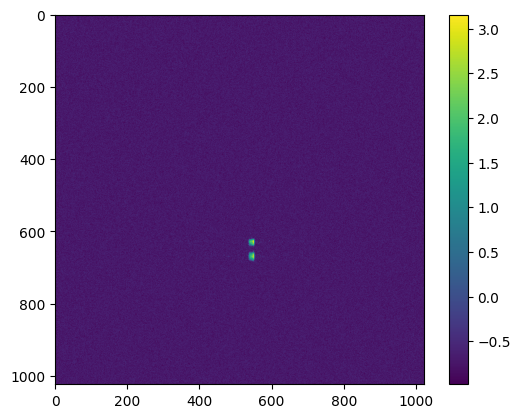

In [32]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [33]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### Without removing noise

In [35]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

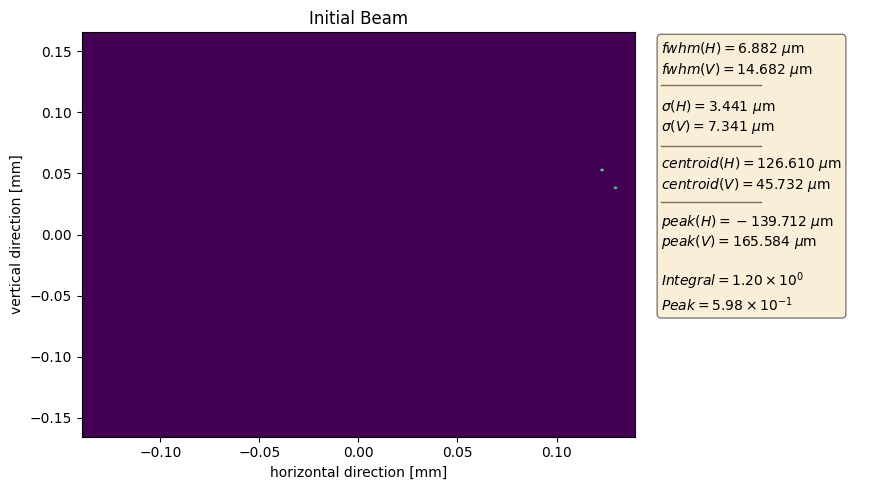

In [36]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [37]:
hist_pert.data_2D.max()

23.365307665038603

In [39]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 2.175e+00
Perturbed beam system log_weighted_sum_intensity: 1.224e+01


In [40]:
opt_params = OptimizationParameters()

In [41]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
)

In [42]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [43]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-12 16:21:38,941] A new study created in memory with name: no-name-63e221c1-5b70-46af-9889-f1a5a961edcc


In [44]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-12 16:21:51,619] Trial 0 finished with values: [2.175053675032646, 12.241710301020817] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:21:58,909] Trial 1 finished with values: [2.175053675032646, 12.243743972698965] and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:22:06,012] Trial 2 finished with values: [2.175053675032646, 12.242198373890073] and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:22:13,234] Trial 3 finished with values: [2.175053675032646, 12.242005038911733] and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:22:19,187] Trial 4 finished with values: [1.4028133914202776, 12.241401931215588] and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:22:26,254] Trial 5 finished with values: [1.4027644487397237, 12.241044441161364] and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:22:33,632] Trial 6 finished with values: [1.402662793100345, 12.241914983347122] and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:22:41,010] Trial 7 finished with values: [2.175053675032646, 12.241131613527267] and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:22:48,381] Trial 8 finished with values: [2.175053675032646, 12.240864502203696] and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:22:55,801] Trial 9 finished with values: [2.175053675032646, 12.24391597182977] and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisib

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:23:14,464] Trial 10 finished with values: [2.175053675032646, 12.240913753705431] and parameters: {'hb_1': 22.0, 'hb_2': -17.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.026900000000000007, 'vb_bender': 19.0, 'vb_pitch': -0.00106, 'vb_trans': 0.0233}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:23:33,248] Trial 11 finished with values: [2.175053675032646, 12.24196883299832] and parameters: {'hb_1': -25.0, 'hb_2': -9.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': -0.024399999999999998, 'vb_bender': -5.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.005600000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] a

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:23:52,198] Trial 12 finished with values: [2.175053675032646, 12.24157766031225] and parameters: {'hb_1': -5.0, 'hb_2': 5.0, 'hb_pitch': 0.0005, 'hb_trans': -0.014799999999999999, 'vb_bender': -20.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.021500000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, b

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:24:11,030] Trial 13 finished with values: [2.175053675032646, 12.242131122812653] and parameters: {'hb_1': 3.0, 'hb_2': -25.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.0032999999999999974, 'vb_bender': -14.0, 'vb_pitch': 0.00168, 'vb_trans': 0.005500000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:24:26,879] Trial 14 finished with values: [2.175053675032646, 12.242996808081706] and parameters: {'hb_1': 4.0, 'hb_2': 7.0, 'hb_pitch': -0.0016, 'hb_trans': 0.025800000000000003, 'vb_bender': 16.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': 0.004300000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, bu

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:24:44,310] Trial 15 finished with values: [1.40270515051206, 12.242142992021265] and parameters: {'hb_1': 0.0, 'hb_2': -6.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.028900000000000002, 'vb_bender': 14.0, 'vb_pitch': 0.0014600000000000004, 'vb_trans': 0.008400000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:25:02,753] Trial 16 finished with values: [2.175053675032646, 12.242296895743069] and parameters: {'hb_1': -22.0, 'hb_2': -1.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.012799999999999999, 'vb_bender': -13.0, 'vb_pitch': 0.00068, 'vb_trans': -0.009799999999999996}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.00

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:25:20,653] Trial 17 finished with values: [2.175053675032646, 12.241729121069449] and parameters: {'hb_1': 22.0, 'hb_2': 10.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0267, 'vb_bender': 15.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.009100000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:25:38,406] Trial 18 finished with values: [2.175053675032646, 12.24167074911319] and parameters: {'hb_1': -7.0, 'hb_2': -17.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.026500000000000003, 'vb_bender': -10.0, 'vb_pitch': -0.0012799999999999999, 'vb_trans': 0.015300000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] a

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:25:57,067] Trial 19 finished with values: [1.4026373780393353, 12.241541074893544] and parameters: {'hb_1': -12.0, 'hb_2': 20.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.0182, 'vb_bender': 8.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': -0.0165}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the ran

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:26:16,174] Trial 20 finished with values: [2.175053675032646, 12.242563665388136] and parameters: {'hb_1': -22.0, 'hb_2': 3.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': 0.0006000000000000033, 'vb_bender': -9.0, 'vb_pitch': -0.0004599999999999999, 'vb_trans': 0.0030000000000000027}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:26:33,609] Trial 21 finished with values: [2.175053675032646, 12.241886864602881] and parameters: {'hb_1': -1.0, 'hb_2': 6.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': -0.028999999999999998, 'vb_bender': -16.0, 'vb_pitch': -0.00098, 'vb_trans': 0.021300000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:26:52,214] Trial 22 finished with values: [2.175053675032646, 12.241972101158174] and parameters: {'hb_1': 25.0, 'hb_2': -17.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.023399999999999997, 'vb_bender': -9.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': 0.020700000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:27:11,194] Trial 23 finished with values: [1.402742800470942, 12.241050978666518] and parameters: {'hb_1': -6.0, 'hb_2': -18.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.026600000000000006, 'vb_bender': 10.0, 'vb_pitch': -0.002, 'vb_trans': -0.016599999999999997}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:27:29,151] Trial 24 finished with values: [2.175053675032646, 12.242753294844526] and parameters: {'hb_1': -11.0, 'hb_2': -2.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.011199999999999998, 'vb_bender': -11.0, 'vb_pitch': -0.00152, 'vb_trans': 0.0187}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the ran

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:27:47,264] Trial 25 finished with values: [2.175053675032646, 12.242555039764662] and parameters: {'hb_1': -13.0, 'hb_2': -7.0, 'hb_pitch': -0.0005, 'hb_trans': 0.0039000000000000007, 'vb_bender': -17.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': -0.016399999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:28:06,804] Trial 26 finished with values: [2.175053675032646, 12.240919925286017] and parameters: {'hb_1': -12.0, 'hb_2': -9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.016600000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0018000000000000004, 'vb_trans': -0.0208}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:28:26,406] Trial 27 finished with values: [2.175053675032646, 12.241073297713996] and parameters: {'hb_1': 22.0, 'hb_2': -4.0, 'hb_pitch': 0.0015, 'hb_trans': -0.0286, 'vb_bender': 20.0, 'vb_pitch': 8.000000000000021e-05, 'vb_trans': -0.0278}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisib

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:28:45,438] Trial 28 finished with values: [2.175053675032646, 12.2433148217385] and parameters: {'hb_1': -23.0, 'hb_2': 6.0, 'hb_pitch': -0.0015, 'hb_trans': -0.0215, 'vb_bender': 19.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.015100000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range i

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:29:03,816] Trial 29 finished with values: [1.4026439671734452, 12.243536153558757] and parameters: {'hb_1': 10.0, 'hb_2': 2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.009499999999999998, 'vb_bender': 5.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0236}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:29:22,746] Trial 30 finished with values: [2.175053675032646, 12.241586324221208] and parameters: {'hb_1': -17.0, 'hb_2': 13.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.003199999999999998, 'vb_bender': -2.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': -0.009599999999999997}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002]

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:29:40,870] Trial 31 finished with values: [2.175053675032646, 12.24190316065617] and parameters: {'hb_1': -5.0, 'hb_2': 19.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.009399999999999999, 'vb_bender': 20.0, 'vb_pitch': -0.0019, 'vb_trans': 0.020700000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:30:00,793] Trial 32 finished with values: [2.175053675032646, 12.241367351369004] and parameters: {'hb_1': -17.0, 'hb_2': -18.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0279, 'vb_bender': -9.0, 'vb_pitch': 0.0009400000000000003, 'vb_trans': -0.0224}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the rang

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:30:19,740] Trial 33 finished with values: [2.175053675032646, 12.243640963375606] and parameters: {'hb_1': -14.0, 'hb_2': -2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.009400000000000006, 'vb_bender': -15.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.010899999999999996}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:30:37,324] Trial 34 finished with values: [2.175053675032646, 12.241113921436776] and parameters: {'hb_1': -5.0, 'hb_2': 11.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0291, 'vb_bender': -9.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': 0.029400000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range i

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:30:56,330] Trial 35 finished with values: [2.175053675032646, 12.24204017172721] and parameters: {'hb_1': -23.0, 'hb_2': 17.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.026000000000000002, 'vb_bender': -5.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': 0.0077000000000000055}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002]

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:31:16,947] Trial 36 finished with values: [1.4027879790877382, 12.24343470992379] and parameters: {'hb_1': -4.0, 'hb_2': -21.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.0005999999999999964, 'vb_bender': -1.0, 'vb_pitch': 0.0016600000000000005, 'vb_trans': -0.0247}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.00

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:31:36,012] Trial 37 finished with values: [2.175053675032646, 12.241341053121396] and parameters: {'hb_1': -23.0, 'hb_2': -15.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.023200000000000005, 'vb_bender': 18.0, 'vb_pitch': 0.0005200000000000001, 'vb_trans': 0.0172}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:31:56,293] Trial 38 finished with values: [1.40270515051206, 12.242206982445396] and parameters: {'hb_1': -9.0, 'hb_2': -8.0, 'hb_pitch': -0.0005, 'hb_trans': -0.013699999999999997, 'vb_bender': 13.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': -0.014599999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:32:15,309] Trial 39 finished with values: [2.175053675032646, 12.24106204082699] and parameters: {'hb_1': -18.0, 'hb_2': -5.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.026800000000000004, 'vb_bender': -16.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0235}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:32:36,313] Trial 40 finished with values: [2.175053675032646, 12.242438527268886] and parameters: {'hb_1': -8.0, 'hb_2': -16.0, 'hb_pitch': 0.0015, 'hb_trans': -0.009399999999999999, 'vb_bender': 4.0, 'vb_pitch': -0.00156, 'vb_trans': 0.012100000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:32:56,877] Trial 41 finished with values: [1.402662793100345, 12.244020877486985] and parameters: {'hb_1': 16.0, 'hb_2': 25.0, 'hb_pitch': -0.0019, 'hb_trans': -0.014299999999999997, 'vb_bender': 11.0, 'vb_pitch': 0.00046000000000000034, 'vb_trans': -0.0163}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the rang

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:33:17,299] Trial 42 finished with values: [2.175053675032646, 12.243169601297318] and parameters: {'hb_1': 11.0, 'hb_2': 14.0, 'hb_pitch': -0.0014, 'hb_trans': 0.019600000000000006, 'vb_bender': -7.0, 'vb_pitch': 0.0007800000000000003, 'vb_trans': -0.015199999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:33:37,556] Trial 43 finished with values: [2.175053675032646, 12.241552776841212] and parameters: {'hb_1': -21.0, 'hb_2': 20.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.025300000000000003, 'vb_bender': -15.0, 'vb_pitch': -0.0009599999999999999, 'vb_trans': -0.000499999999999997}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:33:59,252] Trial 44 finished with values: [1.4027644487397237, 12.24350809427784] and parameters: {'hb_1': 6.0, 'hb_2': 1.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.0005999999999999964, 'vb_bender': 10.0, 'vb_pitch': -0.00192, 'vb_trans': -0.0254}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the rang

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:34:20,593] Trial 45 finished with values: [2.175053675032646, 12.24091176485651] and parameters: {'hb_1': -1.0, 'hb_2': 20.0, 'hb_pitch': 0.0018, 'hb_trans': 0.0033000000000000043, 'vb_bender': -19.0, 'vb_pitch': -0.0018, 'vb_trans': 0.027200000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range i

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:34:40,541] Trial 46 finished with values: [1.40270515051206, 12.241381407426276] and parameters: {'hb_1': 8.0, 'hb_2': -15.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.003199999999999998, 'vb_bender': 14.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': 0.0092}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:35:02,448] Trial 47 finished with values: [2.175053675032646, 12.242688634140796] and parameters: {'hb_1': -10.0, 'hb_2': 21.0, 'hb_pitch': -0.0009, 'hb_trans': -0.005199999999999996, 'vb_bender': -10.0, 'vb_pitch': 0.00042000000000000023, 'vb_trans': -0.010099999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.00

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:35:22,293] Trial 48 finished with values: [1.4027644487397237, 12.241128842110815] and parameters: {'hb_1': -18.0, 'hb_2': 4.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.0208, 'vb_bender': 3.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.0262}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:35:45,681] Trial 49 finished with values: [1.4026439671734452, 12.24255637506043] and parameters: {'hb_1': -11.0, 'hb_2': 15.0, 'hb_pitch': -0.0009, 'hb_trans': -0.021599999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.0005, 'vb_trans': 0.008}. 


In [ ]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
# plt.xscale('log')
# plt.yscale('log')
plt.scatter(*attribs_focus.values(), color="green")

In [46]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

2.8432394994955583 207118.10004226328
3.2818332462671345 207080.83478006403
2.8431894798443142 207220.98742384653
2.8432246008647897 207119.45408233567
2.843224753392303 207187.9036148944


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.
[1.4027644487397237, 12.241044441161364]


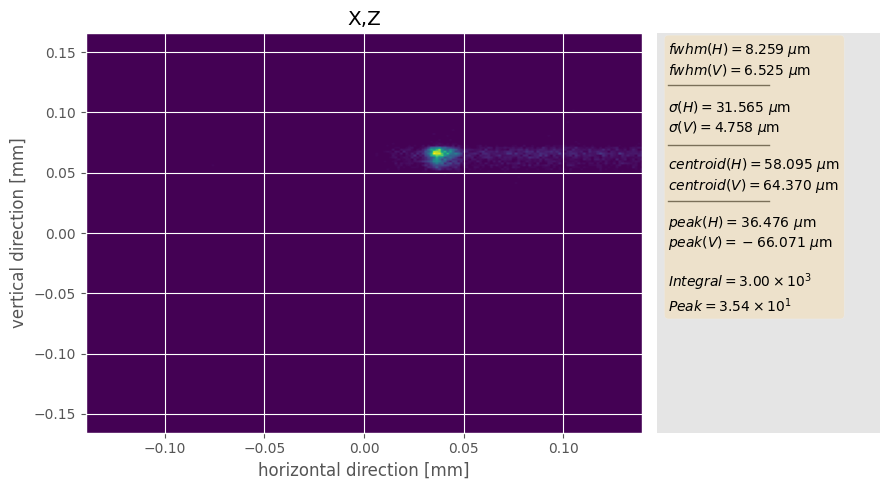

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.
[2.175053675032646, 12.240864502203696]


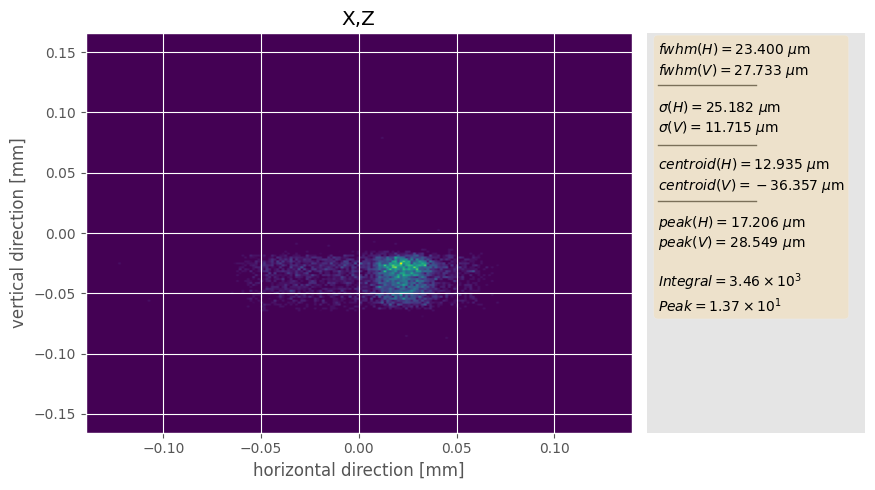

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.
[1.4026373780393353, 12.241541074893544]


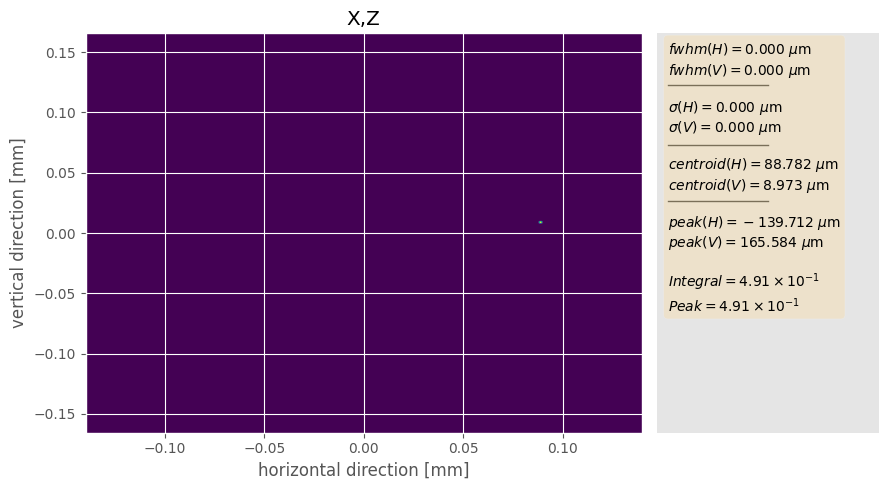

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.
[1.402742800470942, 12.241050978666518]


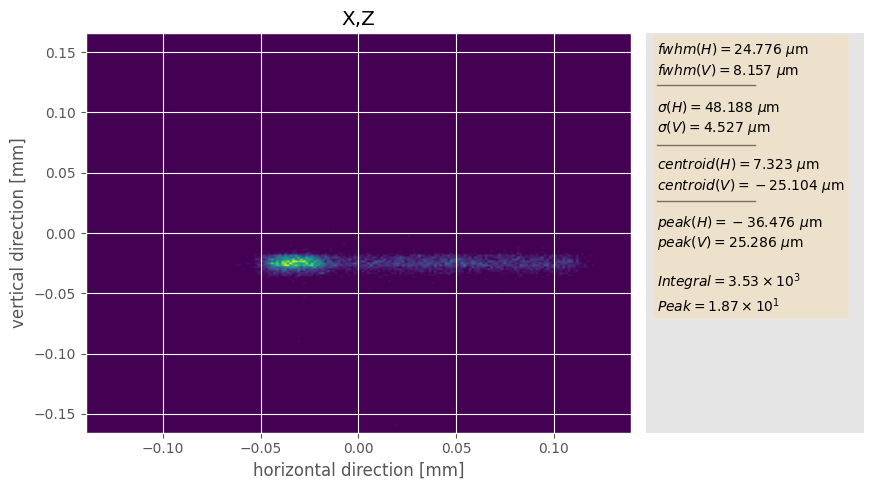

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.
[1.40270515051206, 12.241381407426276]


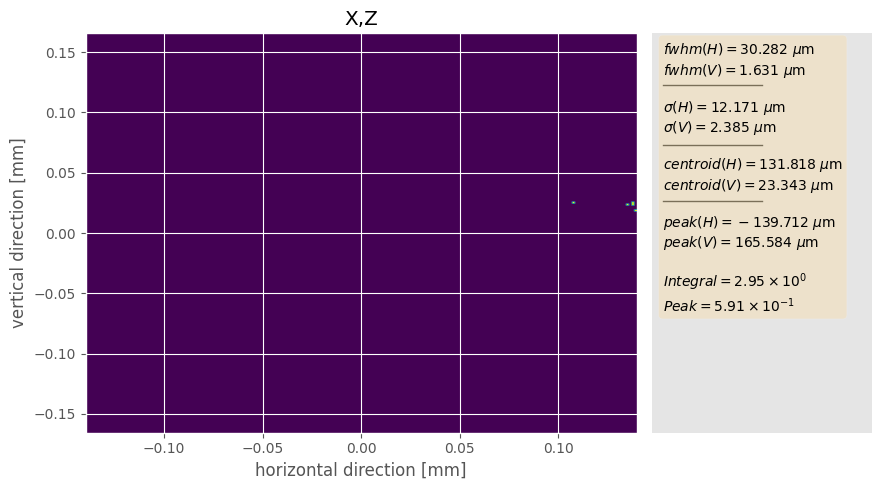

In [47]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

### After removing noise

In [48]:
cp2 = dt.replace(cp, calculate_over_noise=True)

In [49]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


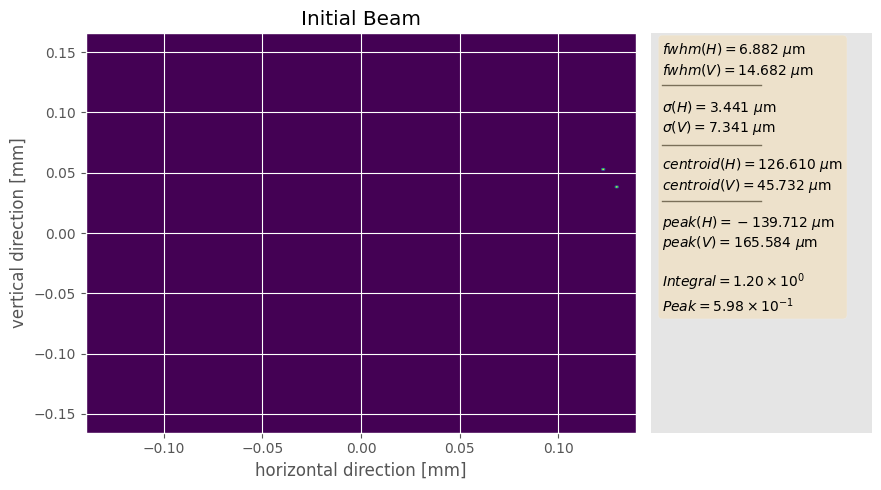

In [50]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [51]:
hist_pert.data_2D.max()

23.375662492433428

In [52]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 2.175e+00
Perturbed beam system log_weighted_sum_intensity: 1.224e+01


In [53]:
opt_params = OptimizationParameters()

In [54]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
)

In [55]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [56]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-12 16:36:45,004] A new study created in memory with name: no-name-0257c0bd-3ce7-4e09-b455-ec7c0bdc196e


In [ ]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-12 16:36:53,043] Trial 0 finished with values: [2.175053675032646, 12.241499844197753] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:37:00,601] Trial 1 finished with values: [2.175053675032646, 12.243647094908672] and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:37:07,869] Trial 2 finished with values: [2.175053675032646, 12.242383612838621] and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:37:15,136] Trial 3 finished with values: [2.175053675032646, 12.24206233371807] and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:37:21,126] Trial 4 finished with values: [1.4027879790877382, 12.240724472446301] and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:37:28,213] Trial 5 finished with values: [1.4027644487397237, 12.24115113860309] and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:37:35,663] Trial 6 finished with values: [1.402662793100345, 12.241661427171632] and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:37:43,146] Trial 7 finished with values: [2.175053675032646, 12.241214033376787] and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:37:50,661] Trial 8 finished with values: [2.175053675032646, 12.240687368182474] and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:37:58,230] Trial 9 finished with values: [2.175053675032646, 12.244170604872144] and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisi

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:38:14,311] Trial 10 finished with values: [2.175053675032646, 12.240971490478836] and parameters: {'hb_1': 22.0, 'hb_2': -17.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.026900000000000007, 'vb_bender': 19.0, 'vb_pitch': -0.00106, 'vb_trans': 0.0233}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:38:31,594] Trial 11 finished with values: [2.175053675032646, 12.241954173867818] and parameters: {'hb_1': -25.0, 'hb_2': -9.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': -0.024399999999999998, 'vb_bender': -5.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.005600000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:38:48,007] Trial 12 finished with values: [2.175053675032646, 12.241527911418393] and parameters: {'hb_1': -5.0, 'hb_2': 5.0, 'hb_pitch': 0.0005, 'hb_trans': -0.014799999999999999, 'vb_bender': -20.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.021500000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:39:05,058] Trial 13 finished with values: [2.175053675032646, 12.242566261394405] and parameters: {'hb_1': 3.0, 'hb_2': -25.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.0032999999999999974, 'vb_bender': -14.0, 'vb_pitch': 0.00168, 'vb_trans': 0.005500000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:39:20,886] Trial 14 finished with values: [2.175053675032646, 12.24296615260834] and parameters: {'hb_1': 4.0, 'hb_2': 7.0, 'hb_pitch': -0.0016, 'hb_trans': 0.025800000000000003, 'vb_bender': 16.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': 0.004300000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:39:37,631] Trial 15 finished with values: [1.40270515051206, 12.242027416756654] and parameters: {'hb_1': 0.0, 'hb_2': -6.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.028900000000000002, 'vb_bender': 14.0, 'vb_pitch': 0.0014600000000000004, 'vb_trans': 0.008400000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:39:55,732] Trial 16 finished with values: [2.175053675032646, 12.242745643818637] and parameters: {'hb_1': -22.0, 'hb_2': -1.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.012799999999999999, 'vb_bender': -13.0, 'vb_pitch': 0.00068, 'vb_trans': -0.009799999999999996}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.00

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:40:14,452] Trial 17 finished with values: [2.175053675032646, 12.241561375387839] and parameters: {'hb_1': 22.0, 'hb_2': 10.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0267, 'vb_bender': 15.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.009100000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:40:33,601] Trial 18 finished with values: [2.175053675032646, 12.241708769687566] and parameters: {'hb_1': -7.0, 'hb_2': -17.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.026500000000000003, 'vb_bender': -10.0, 'vb_pitch': -0.0012799999999999999, 'vb_trans': 0.015300000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:40:52,657] Trial 19 finished with values: [1.4026373780393353, 12.24164564476391] and parameters: {'hb_1': -12.0, 'hb_2': 20.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.0182, 'vb_bender': 8.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': -0.0165}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the rang

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:41:10,606] Trial 20 finished with values: [2.175053675032646, 12.242869700194811] and parameters: {'hb_1': -22.0, 'hb_2': 3.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': 0.0006000000000000033, 'vb_bender': -9.0, 'vb_pitch': -0.0004599999999999999, 'vb_trans': 0.0030000000000000027}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:41:29,136] Trial 21 finished with values: [2.175053675032646, 12.241351015460294] and parameters: {'hb_1': -1.0, 'hb_2': 6.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': -0.028999999999999998, 'vb_bender': -16.0, 'vb_pitch': -0.00098, 'vb_trans': 0.021300000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:41:47,723] Trial 22 finished with values: [2.175053675032646, 12.242137829547922] and parameters: {'hb_1': 25.0, 'hb_2': -17.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.023399999999999997, 'vb_bender': -9.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': 0.020700000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:42:06,937] Trial 23 finished with values: [1.402742800470942, 12.240649864415149] and parameters: {'hb_1': -6.0, 'hb_2': -18.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.026600000000000006, 'vb_bender': 10.0, 'vb_pitch': -0.002, 'vb_trans': -0.016599999999999997}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:42:27,031] Trial 24 finished with values: [2.175053675032646, 12.242850912667155] and parameters: {'hb_1': -11.0, 'hb_2': -2.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.011199999999999998, 'vb_bender': -11.0, 'vb_pitch': -0.00152, 'vb_trans': 0.0187}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the ran

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:42:46,199] Trial 25 finished with values: [2.175053675032646, 12.243055737118864] and parameters: {'hb_1': -13.0, 'hb_2': -7.0, 'hb_pitch': -0.0005, 'hb_trans': 0.0039000000000000007, 'vb_bender': -17.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': -0.016399999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:43:06,521] Trial 26 finished with values: [2.175053675032646, 12.24115275957858] and parameters: {'hb_1': -12.0, 'hb_2': -9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.016600000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0018000000000000004, 'vb_trans': -0.0208}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:43:26,431] Trial 27 finished with values: [2.175053675032646, 12.241057372424336] and parameters: {'hb_1': 22.0, 'hb_2': -4.0, 'hb_pitch': 0.0015, 'hb_trans': -0.0286, 'vb_bender': 20.0, 'vb_pitch': 8.000000000000021e-05, 'vb_trans': -0.0278}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisib

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:43:45,570] Trial 28 finished with values: [2.175053675032646, 12.242798888063307] and parameters: {'hb_1': -23.0, 'hb_2': 6.0, 'hb_pitch': -0.0015, 'hb_trans': -0.0215, 'vb_bender': 19.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.015100000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:44:06,755] Trial 29 finished with values: [1.4026439671734452, 12.243364131789845] and parameters: {'hb_1': 10.0, 'hb_2': 2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.009499999999999998, 'vb_bender': 5.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0236}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:44:28,200] Trial 30 finished with values: [2.175053675032646, 12.241114964486194] and parameters: {'hb_1': -17.0, 'hb_2': 13.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.003199999999999998, 'vb_bender': -2.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': -0.009599999999999997}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002]

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:44:47,658] Trial 31 finished with values: [2.175053675032646, 12.241860690484836] and parameters: {'hb_1': -5.0, 'hb_2': 19.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.009399999999999999, 'vb_bender': 20.0, 'vb_pitch': -0.0019, 'vb_trans': 0.020700000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:45:08,174] Trial 32 finished with values: [2.175053675032646, 12.241287413578346] and parameters: {'hb_1': -17.0, 'hb_2': -18.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0279, 'vb_bender': -9.0, 'vb_pitch': 0.0009400000000000003, 'vb_trans': -0.0224}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the rang

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:45:28,591] Trial 33 finished with values: [2.175053675032646, 12.24394883337834] and parameters: {'hb_1': -14.0, 'hb_2': -2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.009400000000000006, 'vb_bender': -15.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.010899999999999996}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002]

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:45:48,077] Trial 34 finished with values: [2.175053675032646, 12.240904273479] and parameters: {'hb_1': -5.0, 'hb_2': 11.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0291, 'vb_bender': -9.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': 0.029400000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is n

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:46:08,690] Trial 35 finished with values: [2.175053675032646, 12.242235940984202] and parameters: {'hb_1': -23.0, 'hb_2': 17.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.026000000000000002, 'vb_bender': -5.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': 0.0077000000000000055}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:46:30,939] Trial 36 finished with values: [1.4027879790877382, 12.243523538757556] and parameters: {'hb_1': -4.0, 'hb_2': -21.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.0005999999999999964, 'vb_bender': -1.0, 'vb_pitch': 0.0016600000000000005, 'vb_trans': -0.0247}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:46:52,082] Trial 37 finished with values: [2.175053675032646, 12.241247035951194] and parameters: {'hb_1': -23.0, 'hb_2': -15.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.023200000000000005, 'vb_bender': 18.0, 'vb_pitch': 0.0005200000000000001, 'vb_trans': 0.0172}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:47:15,328] Trial 38 finished with values: [1.40270515051206, 12.241898609374429] and parameters: {'hb_1': -9.0, 'hb_2': -8.0, 'hb_pitch': -0.0005, 'hb_trans': -0.013699999999999997, 'vb_bender': 13.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': -0.014599999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:47:37,239] Trial 39 finished with values: [2.175053675032646, 12.240828368072039] and parameters: {'hb_1': -18.0, 'hb_2': -5.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.026800000000000004, 'vb_bender': -16.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0235}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the rang

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:47:58,851] Trial 40 finished with values: [2.175053675032646, 12.242087803446474] and parameters: {'hb_1': -8.0, 'hb_2': -16.0, 'hb_pitch': 0.0015, 'hb_trans': -0.009399999999999999, 'vb_bender': 4.0, 'vb_pitch': -0.00156, 'vb_trans': 0.012100000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:48:21,003] Trial 41 finished with values: [1.402662793100345, 12.244115392880943] and parameters: {'hb_1': 16.0, 'hb_2': 25.0, 'hb_pitch': -0.0019, 'hb_trans': -0.014299999999999997, 'vb_bender': 11.0, 'vb_pitch': 0.00046000000000000034, 'vb_trans': -0.0163}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the rang

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:48:41,704] Trial 42 finished with values: [2.175053675032646, 12.242974242079976] and parameters: {'hb_1': 11.0, 'hb_2': 14.0, 'hb_pitch': -0.0014, 'hb_trans': 0.019600000000000006, 'vb_bender': -7.0, 'vb_pitch': 0.0007800000000000003, 'vb_trans': -0.015199999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:49:00,566] Trial 43 finished with values: [2.175053675032646, 12.241295179673704] and parameters: {'hb_1': -21.0, 'hb_2': 20.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.025300000000000003, 'vb_bender': -15.0, 'vb_pitch': -0.0009599999999999999, 'vb_trans': -0.000499999999999997}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:49:21,067] Trial 44 finished with values: [1.4027644487397237, 12.24337999618545] and parameters: {'hb_1': 6.0, 'hb_2': 1.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.0005999999999999964, 'vb_bender': 10.0, 'vb_pitch': -0.00192, 'vb_trans': -0.0254}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the rang

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 16:49:41,324] Trial 45 finished with values: [2.175053675032646, 12.241047223602715] and parameters: {'hb_1': -1.0, 'hb_2': 20.0, 'hb_pitch': 0.0018, 'hb_trans': 0.0033000000000000043, 'vb_bender': -19.0, 'vb_pitch': -0.0018, 'vb_trans': 0.027200000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


/tmp/ipykernel_3877770/3137896170.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


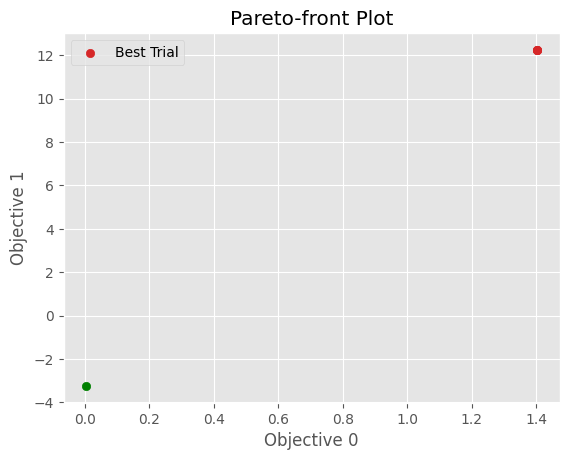

In [62]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
# plt.xscale('log')
# plt.yscale('log')
plt.scatter(*attribs_focus.values(), color="green")

In [63]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

2.8431980220223867 207242.65762864405
2.8431918323693344 207036.39217733804
2.8432460137002167 207241.833004901


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.
[1.4026373780393353, 12.24164564476391]


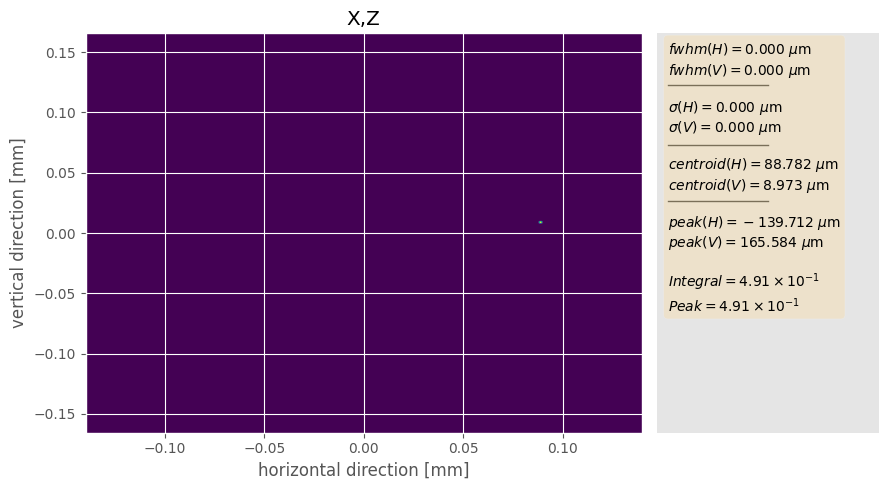

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.
[1.402742800470942, 12.240649864415149]


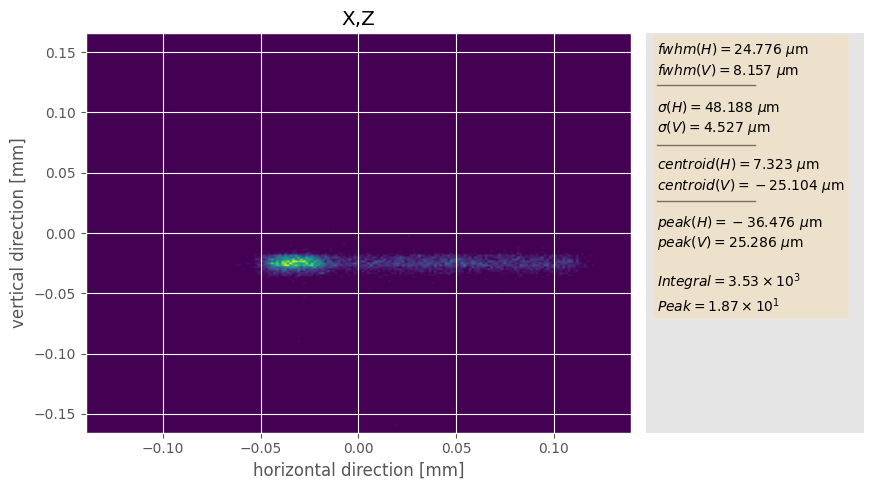

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_67714/Downstream_HKB_bender_profile.dat written to disk.
[1.40270515051206, 12.241641665730862]


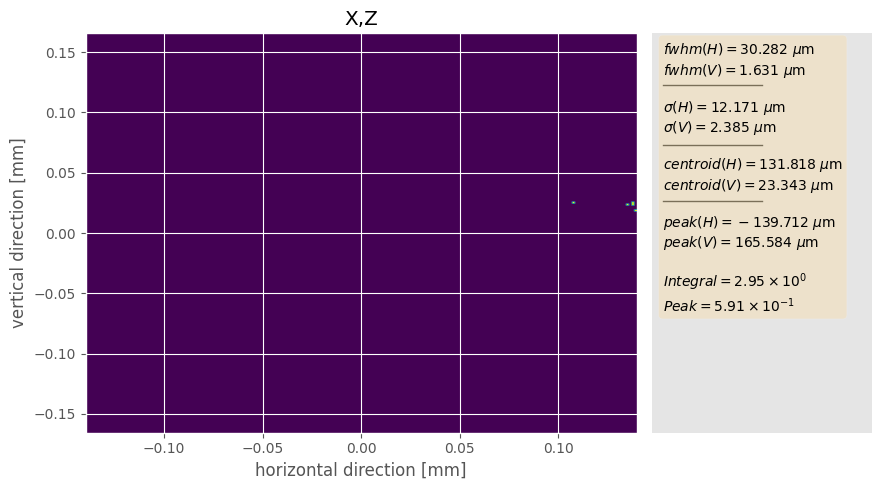

In [64]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()